# Shocks in the locally isothermal terminal velocity approximation


In [168]:
#Pkg.add("")
#Pkg.add("PyPlot")
using Plots;
#pgfplots();
pyplot();
#pyplot();

using LaTeXStrings
#options(jupyter.plot_mimetypes = c("text/plain", "image/png" ));
#=
upscale = 1.0 #8x upscaling in resolution
fntsm = Plots.font("sans-serif", 10.0)
fntlg = Plots.font("sans-serif", 12.0)
default(titlefont=fntlg, guidefont=fntlg, tickfont=fntsm, legendfont=fntsm)
default(size=(800*upscale,600*upscale)) #Plot canvas size
default(dpi=300) #Only for PyPlot - presently broken
=#

### Define preshock parameters

In [178]:
const global p₀=39.0;
const global u₀=0.8;
const global c²=4.0;
const global f₀=2.5; #cs^2*(1-f_d),
const global ρ₀=p₀/f₀;
const global D=ρ₀*u₀;
const global B=ρ₀*u₀^2+p₀;
global ts=0.1;

### Some useful functions 

In [179]:
Rho(D,u) = D/u;
U(B,D,P) = (B-P)/D
function FD(P,B,D) 
    fd=deepcopy(P)
    uu=deepcopy(P)
    ρρ=deepcopy(P)
    i=1
    for (i,p) ∈ enumerate(P)
        u=U(B,D,p)
        ρ=Rho(D,u)
        fd[i]=1-(p/(c²*ρ))
        uu[i]=u
        ρρ[i]=ρ
    end
    return (fd,uu,ρρ)
end

function ρd(fd::Array{Float64,1}, ρ::Array{Float64,1})
    ρ_d=broadcast(*,ρ,fd)
    return ρ_d
end

integrate_trap(f::Array{Float64,1},h::Float64) = 0.5*h*(f[1]+2.0*sum(f[2:end-1])+f[end])
integrate_simpson(f::Array{Float64,1},h::Float64) = 0.3333333333*h*(f[1]+4.0*sum(f[3:2:end-1])+2.0*sum(f[2:2:end-1])+f[end]) 

integrate_simpson (generic function with 1 method)

### Defining Differential EQN.

In [180]:
∂ₓp(p)=(((p*(B-p))-(p₀*(B-p₀)))/D)/(ts*(c²-(p*((B-p)/(D^2)))));

### Runge-Kutta 4 integrator

In [181]:
K₁(p,h)=h*∂ₓp(p);
K₂(p,h)=h*∂ₓp(p+K₁(p,h)/2);
K₃(p,h)=h*∂ₓp(p+K₂(p,h)/2);
K₄(p,h)=h*∂ₓp(p+K₃(p,h));
p₊₁(p,h)=0.166666666*(K₄(p,h)+2.0K₃(p,h)+2.0K₂(p,h)+K₁(p,h)) +p;

function Integrate(x::Array{Float64},pInit)
    p=pInit;
    P₁=pInit;
    for i=1:49999
        p=p₊₁(p,h);
        P₁=vcat(P₁,p);
    end
    P₋=deepcopy(P₁)
    for i=1:length(P₁)
        P₋[i]=P₁[(length(P₁)-i+1)]
    end
    P₋=map(x->2.0pInit-x,P₋);
    Pn=vcat(P₋,P₁);
    return Pn
end

Integrate (generic function with 1 method)

### Calculating P at shock centre
This is done by setting the right and left states as they are free parameters.

In [182]:

#pInit=0.25*(B-sqrt(1.0+4.0*D^2*f₀)-2.0p₀);
pᵣ=10.0;
pInit=0.5*(p₀+pᵣ);

### running the RK solver
Run for 10000 steps to integrate hals the shock, the solution is then mirrored to produce the other side of the pressure profile.

In [183]:
h=0.00005;
x=map(x->h*x,collect(-50000:49999));
Pn=Integrate(x,pInit);


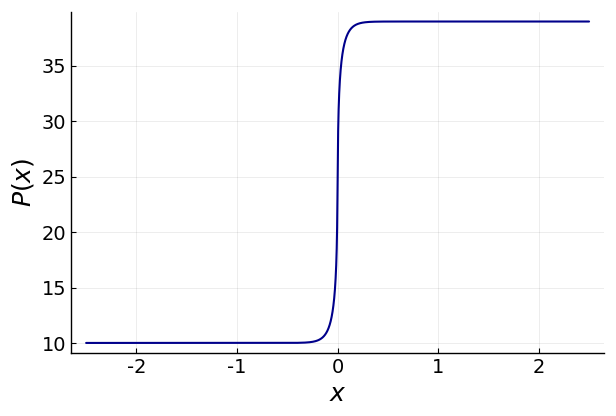

In [184]:
plot(x,Pn,xlabel=L"x",ylabel=L"P(x)",tickfont=font(14),color=:darkblue,guidefont=font(18), legend=false, linewidth=1.5)
savefig("pressureShock.pdf");

In [185]:
Fd=FD(Pn,B,D);

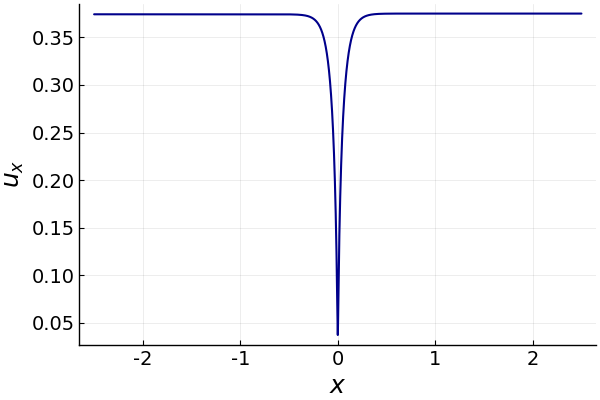

In [186]:
plot(x,Fd[1],xlabel=L"x",ylabel=L"u_x",tickfont=font(14),color=:darkblue,guidefont=font(18), legend=false, linewidth=1.5)
#plot!(x,Fd[2],xlabel="x",ylabel="Y", label="v")
#plot!(x,Fd[3],xlabel="x",ylabel="Y", label="rho")

# Two fluid stationary shocks
calculating the two fluid shock profile

Integration is done using a simple solver for systems of ODEs. The solver takes an IVP and integrates it using an explicit RK method defined by the user using a Butcher tableau.

In [187]:
push!(LOAD_PATH,".")
using RK

### Defining the ODE

In [188]:
f=0.5;
rho_g0=(1-Fd[1][1])*Fd[3][1];
rho_d0=Fd[1][1]*Fd[3][1];
println("rho=",rho_g0+rho_d0)
u0=Fd[2][1]
rho_gR=(1-Fd[1][end])*Fd[3][end];
u_gR=Fd[2][end];
u_dR=u_gR;
Bg=rho_g0*u0;
println("Bg0=",Bg)
Bd=rho_d0*u0;
println("Bd0=",Bd)
d=rho_g0*(u0^2+c²)+rho_d0*(u0^2);
println("D0=",d)
yDash(x,y)=-(Bd/ts)*((y[1]^2)*(Bd*Bg-d*y[1]+Bg^2+c²*y[1]^2))/((d*y[1]-Bg^2-c²*(y[1]^2)+Bd^2)*(y[1]^2*c²-Bg^2))
problem=[yDash]
trange=0.00005:0.00005:2.5
init=[rho_g0+1.405]
ivp=ivpSystem(problem,init)

rho=3.9952390724404454
Bg0=7.809294871797532
Bd0=4.670705128202468
D0=48.983999999999995


ivpSystem(Function[yDash], [3.905])

In [189]:
Sol=integrateRK(ivp,trange,rk4)

Dict{String,Array{Float64,N} where N} with 2 entries:
  "t" => [5.0e-5, 0.0001, 0.00015, 0.0002, 0.00025, 0.0003, 0.00035, 0.0004, 0.…
  "y" => [3.905 4.25994 … 9.746 9.746]

In [190]:
ynew=zeros(length(Sol["y"][1,:]));
ynew=ynew.+rho_g0;
ynew=vcat(ynew,Sol["y"][1,:]);

In [191]:
ug=Bg./ynew;
ud=(d.- (ynew.*(ug.^2 .+c²)))./Bd#(d.-ug.*Bg.-ynew.*c²)./Bd;
rhod=Bd./ud;
u=(rhod.*ud)./(rhod.+ynew) .+ (ynew.*ug)./(rhod.+ynew);
rho=rhod+ynew;
fdArray=rhod./rho;

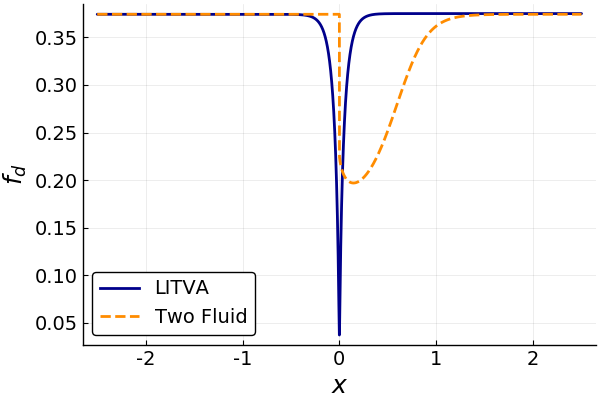

In [202]:
plot(x,Fd[1],xlabel=L"x",ylabel=L"$f_d$",tickfont=font(14),color=:darkblue,guidefont=font(18),legendfont=font(14), linewidth=2,label="LITVA")
plot!(x,fdArray,xlabel=L"x",ylabel=L"$f_d$",tickfont=font(14),color=:darkorange,guidefont=font(18),legendfont=font(14), linewidth=2,linestyle=:dash, label="Two Fluid")

In [203]:
savefig("fdComp.pdf");

In [194]:
ug[1]

3.1237179487175815